<a href="https://colab.research.google.com/github/ali3brt/-Ali3brt-s-Machine-Learning-and-Deep-Learning-Projects/blob/main/ad_with_cnn_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Overview

The **PTB Diagnostic ECG Database** is a collection of 14,552 ECG recordings sourced from Physionet's PTB Diagnostic Database. These ECG signals are categorized into two classes: normal heartbeats and those affected by cardiac abnormalities. The dataset is sampled at 125Hz, providing high-resolution data for in-depth analysis.

> Let's delve into some essential details about the PTB Diagnostic ECG Database:
>
> - **Number of Samples:** 14,552
> - **Number of Categories:** 2
> - **Sampling Frequency:** 125Hz
> - **Data Source:** Physionet's PTB Diagnostic Database

## Using Transposed Convolution has improved the model significantly
|                      | Accuracy  | Precision | Recall   | F1 Score  |
|----------------------|-----------|-----------|----------|-----------|
| With upsampling      | 71.99%    | 49.78%    | 87.91%   | 63.57%    |
| With transposed conv | 76.93%    | 55.23%    | 89.81%   | 68.40%    |

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams["figure.figsize"] = (6, 4)
plt.style.use("ggplot")
import tensorflow as tf
from tensorflow import data
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

In [2]:
import os
import zipfile
import pandas as pd

# Path to your ZIP file
zip_file_path = "ptb_diagnostic.zip"  # Replace with the correct path if needed
extracted_path = "./extracted"  # Directory where files will be extracted

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Listing all extracted files
for dirname, _, filenames in os.walk(extracted_path):
    for filename in filenames:
        print(f"Extracted: {os.path.join(dirname, filename)}")

# Load CSV files
normal_csv_path = os.path.join(extracted_path, "ptbdb_normal.csv")
anomaly_csv_path = os.path.join(extracted_path, "ptbdb_abnormal.csv")

# Read the CSVs into DataFrames
normal_df = pd.read_csv(normal_csv_path).iloc[:, :-1]
anomaly_df = pd.read_csv(anomaly_csv_path).iloc[:, :-1]

# Display the first few rows of the normal DataFrame
print("Normal Heartbeat Data:")
print(normal_df.head())

# Display the first few rows of the anomaly DataFrame
print("Anomalous Heartbeat Data:")
print(anomaly_df.head())

Extracted: ./extracted/mitbih_train.csv
Extracted: ./extracted/ptbdb_normal.csv
Extracted: ./extracted/ptbdb_abnormal.csv
Extracted: ./extracted/mitbih_test.csv
Normal Heartbeat Data:
   1.000000000000000000e+00  9.003241658210754395e-01  \
0                  1.000000                  0.794681   
1                  0.909029                  0.791482   
2                  1.000000                  0.478893   
3                  1.000000                  0.867238   
4                  0.948983                  0.505265   

   3.585899472236633301e-01  5.145867168903350830e-02  \
0                  0.375387                  0.116883   
1                  0.423169                  0.186712   
2                  0.056760                  0.064176   
3                  0.201360                  0.099349   
4                  0.004176                  0.022513   

   4.659643396735191345e-02  1.268233358860015869e-01  \
0                  0.000000                  0.171923   
1               

# EDA

In [3]:
print("Shape of Normal data", normal_df.shape)
print("Shape of Abnormal data", anomaly_df.shape)

Shape of Normal data (4045, 187)
Shape of Abnormal data (10505, 187)


The code below generates a visual comparison between two randomly selected ECG signal samples: one from the "Normal" dataset and the other from the "Anomaly" dataset. This side-by-side plot enables a direct visual assessment of ECG signal patterns between normal and anomalous cases.

In [4]:
def plot_sample(normal, anomaly):
    index = np.random.randint(0, len(normal_df), 2)

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    ax[0].plot(normal.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[0].plot(normal.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[0].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[0].set_title("Normal")

    ax[1].plot(anomaly.iloc[index[0], :].values, label=f"Case {index[0]}")
    ax[1].plot(anomaly.iloc[index[1], :].values, label=f"Case {index[1]}")
    ax[1].legend(shadow=True, frameon=True, facecolor="inherit", loc=1, fontsize=9)
    ax[1].set_title("Anomaly")

    plt.tight_layout()
    plt.show()

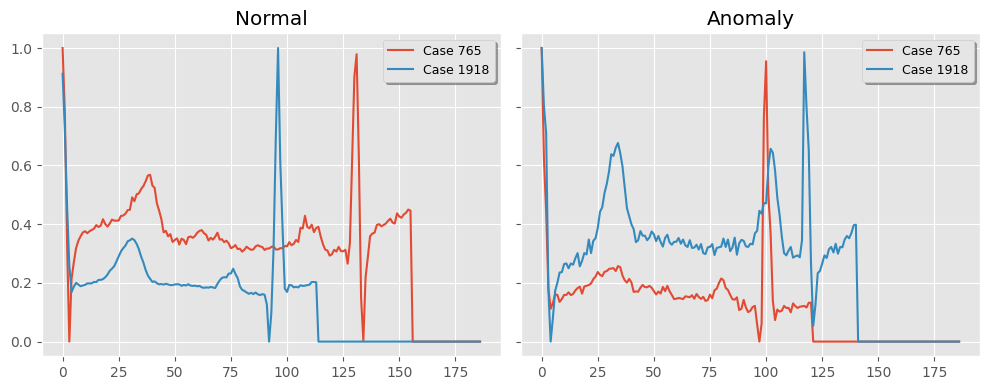

In [5]:
plot_sample(normal_df, anomaly_df)

In [6]:
CLASS_NAMES = ["Normal", "Anomaly"]

normal_df_copy = normal_df.copy()
anomaly_df_copy = anomaly_df.copy()
print(anomaly_df_copy.columns.equals(normal_df_copy.columns))

False


In [7]:
normal_df_copy = normal_df_copy.set_axis(range(1, 188), axis=1)
anomaly_df_copy = anomaly_df_copy.set_axis(range(1, 188), axis=1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
anomaly_df_copy = anomaly_df_copy.assign(target = CLASS_NAMES[1])


df = pd.concat((normal_df_copy, anomaly_df_copy))

## Smoothed Mean Plot for Class Comparison

In this Python code, a function called `plot_smoothed_mean` is defined for creating smoothed mean plots. It takes input data, a class name, and a step size as parameters. The function calculates the rolling mean and standard deviation of the data with the specified step size, then plots the smoothed mean along with a shaded area representing the margin of three times the standard deviation.

The code also demonstrates the use of this function to compare the smoothed means of different classes. It creates a subplot with two panels, each representing a different class. The data for each class is grouped, and the mean is computed before passing it to the `plot_smoothed_mean` function. This allows for visualizing how the smoothed means of different classes compare.

The resulting plot provides insights into how the means of different classes vary over time or some other variable represented by the data, with shaded areas indicating the uncertainty around the mean estimates.


In [8]:
def plot_smoothed_mean(data, class_name = "normal", step_size=5, ax=None):
    df = pd.DataFrame(data)
    roll_df = df.rolling(step_size)
    smoothed_mean = roll_df.mean().dropna().reset_index(drop=True)
    smoothed_std = roll_df.std().dropna().reset_index(drop=True)
    margin = 3*smoothed_std
    lower_bound = (smoothed_mean - margin).values.flatten()
    upper_bound = (smoothed_mean + margin).values.flatten()

    ax.plot(smoothed_mean.index, smoothed_mean)
    ax.fill_between(smoothed_mean.index, lower_bound, y2=upper_bound, alpha=0.3, color="red")
    ax.set_title(class_name, fontsize=9)

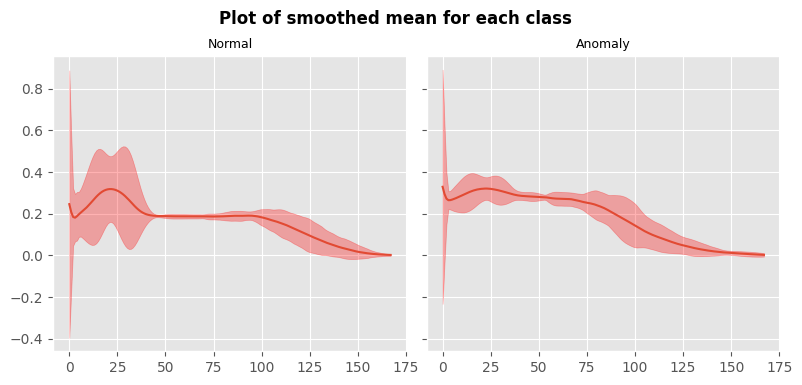

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
axes = axes.flatten()
for i, label in enumerate(CLASS_NAMES, start=1):
    data_group = df.groupby("target")
    data = data_group.get_group(label).mean(axis=0, numeric_only=True).to_numpy()
    plot_smoothed_mean(data, class_name=label, step_size=20, ax=axes[i-1])
fig.suptitle("Plot of smoothed mean for each class", y=0.95, weight="bold")
plt.tight_layout()

## Splitting the data to training and testing set

In [10]:
normal_df.drop("target", axis=1, errors="ignore", inplace=True)
normal = normal_df.to_numpy()
anomaly_df.drop("target", axis=1, errors="ignore", inplace=True)
anomaly = anomaly_df.to_numpy()

X_train, X_test = train_test_split(normal, test_size=0.15, random_state=45, shuffle=True)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}, anomaly shape: {anomaly.shape}")

Train shape: (3438, 187), Test shape: (607, 187), anomaly shape: (10505, 187)


# Building CNN Autoencoder Model

## About Autoencoders: Learning Efficient Data Representations

Autoencoders are a class of neural network architectures commonly used in unsupervised machine learning and deep learning tasks. Their primary purpose is to discover and learn efficient representations of data by encoding it into a lower-dimensional latent space and subsequently decoding it back to its original form. Autoencoders play a crucial role in various applications, such as dimensionality reduction, data denoising, anomaly detection, and generative modeling.

The core components of an autoencoder consist of an encoder and a decoder. The encoder maps input data to the latent space, while the decoder reconstructs the data from its encoded representation. During training, autoencoders aim to minimize the reconstruction error between the input and the decoded output, which results in the learning of meaningful data representations.

Autoencoders offer a versatile tool for feature extraction, data compression, and more, making them a valuable addition to the toolkit of data scientists and machine learning practitioners.


![Autoencoder](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

In [11]:
tf.keras.utils.set_random_seed(1024)

In [12]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim,)),
            layers.Reshape((input_dim, 1)),  # Reshape to 3D for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
        ])
        # Previously, I was using UpSampling. I am trying Transposed Convolution this time around.
        self.decoder = tf.keras.Sequential([
            layers.Conv1DTranspose(latent_dim, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
#             layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])

    def call(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded


input_dim = X_train.shape[-1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 24, 32)              │          63,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 62,688 (244.88 KB)

 Non-trainable params: 576 (2.25 KB)

In [13]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - loss: 0.1778 - val_loss: 0.1137
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0937 - val_loss: 0.0865
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0859 - val_loss: 0.0844
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0845 - val_loss: 0.0849
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0849 - val_loss: 0.0861
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0866 - val_loss: 0.0859
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0845 - val_loss: 0.0841
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0838 - val_loss: 0.0847
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0841 - val_loss: 0.0849
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0838 - val_loss: 0.0853
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0844 - val_loss: 0.0840
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - los

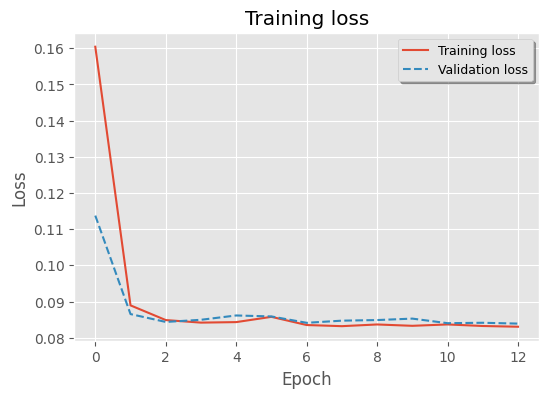

In [14]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [15]:
train_mae = model.evaluate(X_train, X_train, verbose=0)
test_mae = model.evaluate(X_test, X_test, verbose=0)
anomaly_mae = model.evaluate(anomaly_df, anomaly_df, verbose=0)

print("Training dataset error: ", train_mae)
print("Testing dataset error: ", test_mae)
print("Anormaly dataset error: ", anomaly_mae)

Training dataset error:  0.083170585334301
Testing dataset error:  0.08458475023508072
Anormaly dataset error:  0.11937572807073593


In [16]:
def predict(model, X):
    pred = model.predict(X, verbose=False)
    loss = mae(pred, X)
    return pred, loss

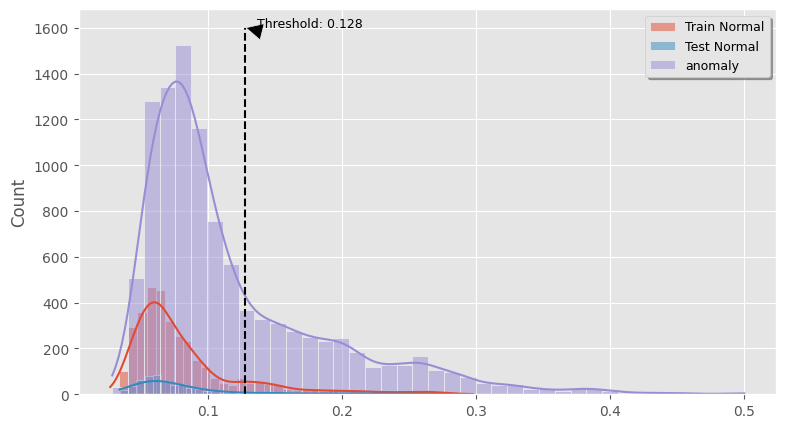

In [17]:
_, train_loss = predict(model, X_train)
_, test_loss = predict(model, X_test)
_, anomaly_loss = predict(model, anomaly)
threshold = np.mean(train_loss) + np.std(train_loss) # Setting threshold for distinguish normal data from anomalous data

bins = 40
plt.figure(figsize=(9, 5), dpi=100)
sns.histplot(np.clip(train_loss, 0, 0.5), bins=bins, kde=True, label="Train Normal")
sns.histplot(np.clip(test_loss, 0, 0.5), bins=bins, kde=True, label="Test Normal")
sns.histplot(np.clip(anomaly_loss, 0, 0.5), bins=bins, kde=True, label="anomaly")

ax = plt.gca()  # Get the current Axes
ylim = ax.get_ylim()
plt.vlines(threshold, 0, ylim[-1], color="k", ls="--")
plt.annotate(f"Threshold: {threshold:.3f}", xy=(threshold, ylim[-1]), xytext=(threshold+0.009, ylim[-1]),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9)
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.show()

In [18]:
def plot_examples(model, data, ax, title):
    pred, loss = predict(model, data)
    ax.plot(data.flatten(), label="Actual")
    ax.plot(pred[0], label = "Predicted")
    ax.fill_between(range(1, 188), data.flatten(), pred[0], alpha=0.3, color="r")
    ax.legend(shadow=True, frameon=True,
              facecolor="inherit", loc=1, fontsize=7)
#                bbox_to_anchor = (0, 0, 0.8, 0.25))

    ax.set_title(f"{title} (loss: {loss[0]:.3f})", fontsize=9.5)

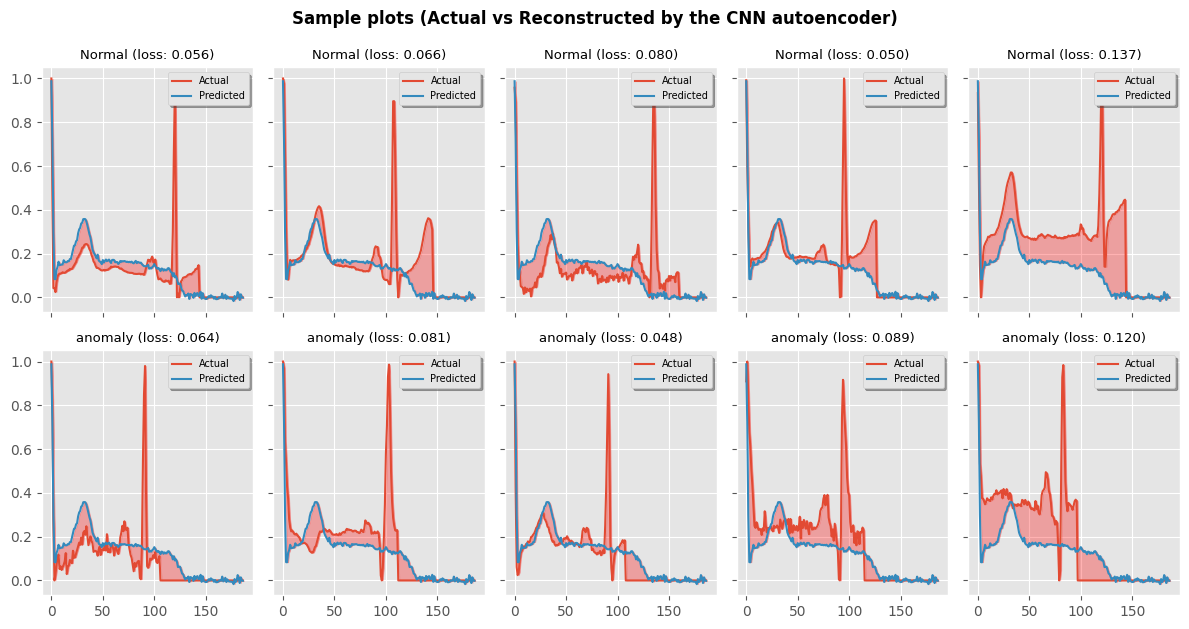

In [19]:
fig, axes = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(12, 6), facecolor="w")
random_indexes = np.random.randint(0, len(X_train), size=5)

for i, idx in enumerate(random_indexes):
    data = X_train[[idx]]
    plot_examples(model, data, ax=axes[0, i], title="Normal")

for i, idx in enumerate(random_indexes):
    data = anomaly[[idx]]
    plot_examples(model, data, ax=axes[1, i], title="anomaly")

plt.tight_layout()
fig.suptitle("Sample plots (Actual vs Reconstructed by the CNN autoencoder)", y=1.04, weight="bold")
fig.savefig("autoencoder.png", dpi=500)
plt.show()

In [20]:
fig.savefig("autoencoder.png", dpi=500, transparent=False, facecolor="white")

## Model Evaluation

In [21]:
def evaluate_model(model, data):
    pred, loss = predict(model, data)
    if id(data) == id(anomaly):
        accuracy = np.sum(loss > threshold)/len(data)
    else:
        accuracy = np.sum(loss <= threshold)/len(data)
    return f"Accuracy: {accuracy:.2%}"

In [22]:
print("Training", evaluate_model(model, X_train))
print("Testing", evaluate_model(model, X_test))
print("Anomaly", evaluate_model(model, anomaly))

Training Accuracy: 86.62%
Testing Accuracy: 86.33%
Anomaly Accuracy: 30.20%


In [23]:
def prepare_labels(model, train, test, anomaly, threshold=threshold):
    ytrue = np.concatenate((np.ones(len(X_train)+len(X_test), dtype=int), np.zeros(len(anomaly), dtype=int)))
    _, train_loss = predict(model, train)
    _, test_loss = predict(model, test)
    _, anomaly_loss = predict(model, anomaly)
    train_pred = (train_loss <= threshold).numpy().astype(int)
    test_pred = (test_loss <= threshold).numpy().astype(int)
    anomaly_pred = (anomaly_loss < threshold).numpy().astype(int)
    ypred = np.concatenate((train_pred, test_pred, anomaly_pred))

    return ytrue, ypred

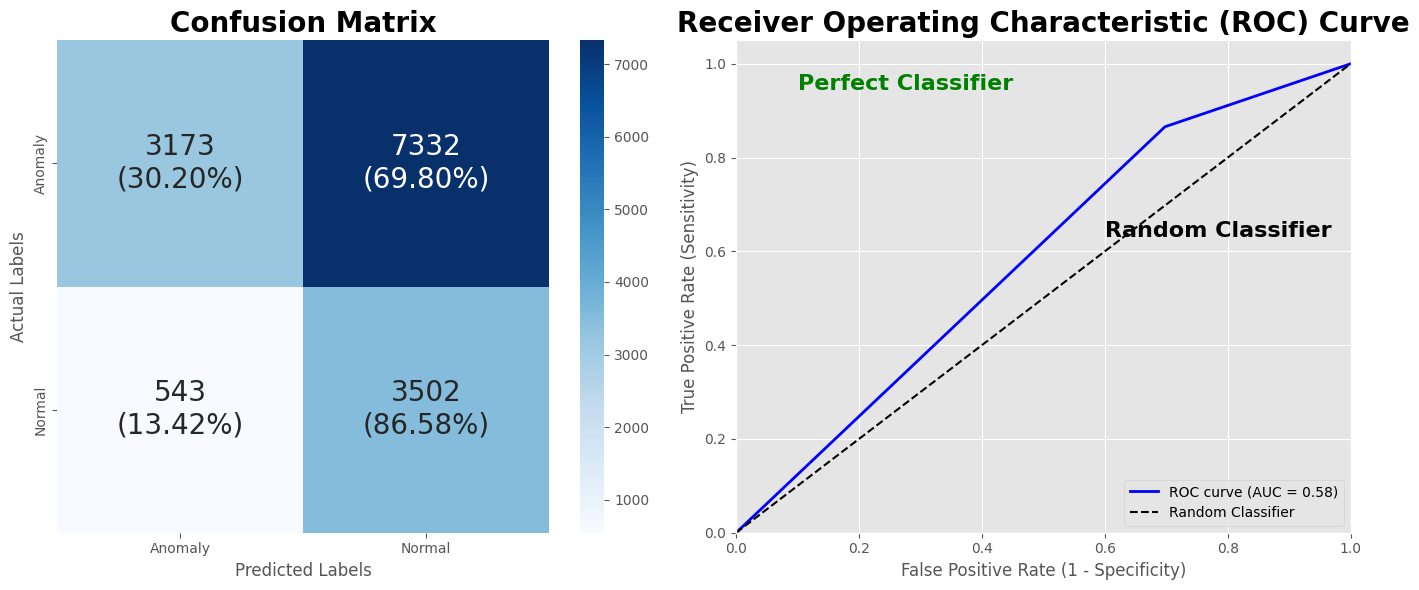

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score
)

def plot_confusion_matrix_and_roc_curve(model, train, test, anomaly, threshold=0.5):
    # Prepare the labels and predictions
    ytrue, ypred = prepare_labels(model, train, test, anomaly, threshold=threshold)

    # Calculate accuracy, precision, recall, and f1 score
    accuracy = accuracy_score(ytrue, ypred)
    precision = precision_score(ytrue, ypred)
    recall = recall_score(ytrue, ypred)
    f1 = f1_score(ytrue, ypred)

    # Confusion matrix
    cm = confusion_matrix(ytrue, ypred)
    cm_norm = confusion_matrix(ytrue, ypred, normalize="true")
    data = np.array([f"{count}\n({pct:.2%})" for count, pct in zip(cm.ravel(), cm_norm.ravel())]).reshape(cm.shape)
    labels = ["Anomaly", "Normal"]

    # Plot confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm, annot=data, fmt="", xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax[0], annot_kws={"size": 20})
    ax[0].set_ylabel("Actual Labels")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_title("Confusion Matrix", weight="bold", size=20)

    fpr, tpr, thresholds = roc_curve(ytrue, ypred)

    auc = roc_auc_score(ytrue, ypred)

    # Plot ROC curve
    ax[1].plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate (1 - Specificity)')
    ax[1].set_ylabel('True Positive Rate (Sensitivity)')
    ax[1].set_title('Receiver Operating Characteristic (ROC) Curve', weight="bold", size=20)
    ax[1].legend(loc="lower right")

    ax[1].annotate('Perfect Classifier', xy=(0, 1), xytext=(0.1, 0.9), textcoords='axes fraction',
                   fontsize=16, color='green', weight='bold')
    ax[1].annotate('Random Classifier', xy=(0.5, 0.5), xytext=(0.6, 0.6), textcoords='axes fraction',
                   fontsize=16, color='black', weight='bold')

    plt.tight_layout()
    fig.savefig("Results.png")
    plt.show()


plot_confusion_matrix_and_roc_curve(model, X_train, X_test, anomaly, threshold=threshold)

## Model Evaluation Metrics

The following evaluation metrics provide a comprehensive assessment of the performance of our model:

- **Accuracy ()**: Accuracy measures the proportion of correct predictions out of all predictions made by the model, indicating an exceptionally high overall classification correctness.

- **Precision ()**: Precision is the percentage of true positive predictions relative to all positive predictions made by the model, signifying the model's precision in correctly identifying positive instances.

- **Recall ()**: Recall, also known as sensitivity, represents the model's ability to accurately identify positive instances out of all actual positive instances, demonstrating a strong capability to capture true positives.

- **F1 Score ()**: The F1 score is a composite metric that balances precision and recall, providing an overall measure of model performance.

In [25]:
ytrue, ypred = prepare_labels(model, X_train, X_test, anomaly, threshold=threshold)
print(classification_report(ytrue, ypred, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      Normal       0.85      0.30      0.45     10505
     Anomaly       0.32      0.87      0.47      4045

    accuracy                           0.46     14550
   macro avg       0.59      0.58      0.46     14550
weighted avg       0.71      0.46      0.45     14550



**Experimental**

In [26]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import EarlyStopping

class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, num_heads=4, ff_dim=128, num_transformer_layers=1):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim, 1)),  # Ensure 3D input for Conv1D
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.GlobalAveragePooling1D(),  # Flatten to 2D for transformer
        ])

        # Transformer Blocks
        self.transformer_blocks = [
            TransformerBlock(latent_dim, num_heads, ff_dim)
            for _ in range(num_transformer_layers)
        ]

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(input_dim * latent_dim, activation='relu'),  # Expand back to sequence
            layers.Reshape((input_dim, latent_dim)),  # Reshape for Conv1DTranspose
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.Conv1DTranspose(1, 3, strides=1, activation='linear', padding="same"),  # Use linear activation
            layers.Reshape((input_dim,)),  # Final output shape matches input_dim
        ])

    def call(self, X):
        # Reshape input for Conv1D layers
        X = tf.expand_dims(X, -1)

        # Encoder
        encoded = self.encoder(X)

        # Transformer Blocks
        # Add a sequence length dimension (1 for global pooling output)
        encoded = tf.expand_dims(encoded, 1)  # Shape: [batch_size, 1, latent_dim]
        for transformer in self.transformer_blocks:
            encoded = transformer(encoded)

        # Decoder
        # Collapse transformer output back into sequence format
        encoded = tf.reshape(encoded, (-1, self.latent_dim))
        decoded = self.decoder(encoded)
        return decoded


class TransformerBlock(layers.Layer):
    def __init__(self, latent_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(latent_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Multi-head attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# Example Usage
# Assuming X_train has shape (batch_size, sequence_length)
X_train = tf.random.normal((128, 187))  # Example data
input_dim = X_train.shape[1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim, num_heads=4, ff_dim=128, num_transformer_layers=2)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()

# Training the model
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)

history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[early_stopping])


Model: "auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 32)                  │          63,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_5 (Sequential)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,264 (247.12 KB)

 Trainable params: 62,688 (244.88 KB)

 Non-trainable params: 576 (2.25 KB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - loss: 0.8021 - val_loss: 1.1106
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.1042 - val_loss: 0.8153
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.8009 - val_loss: 0.8246
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.8073 - val_loss: 0.8172
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.8000 - val_loss: 0.8204
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.8034 - val_loss: 0.8167
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.7987 - val_loss: 0.8179
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.7974 - val_loss: 0.8202
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7975 - val_loss: 0.8203
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7961 - val_loss: 0.8215
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.7970 - val_loss: 0.8192
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7957 - val_loss: 0.8186

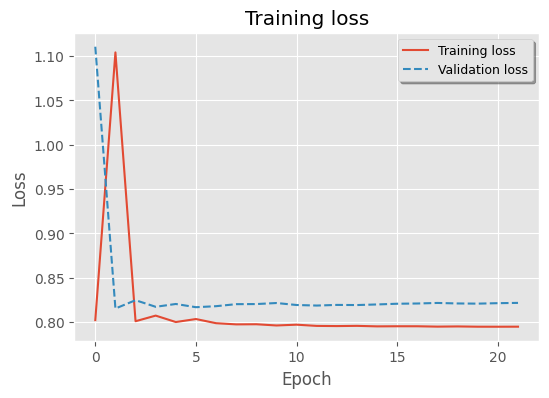

In [27]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

No real improvement

In [28]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers


class TransformerAutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, num_heads=4, ff_dim=128, num_layers=2, dropout_rate=0.1):
        super(TransformerAutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(input_dim)

        # Transformer-based Encoder
        self.encoder_blocks = [
            TransformerBlock(input_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        self.encoder_dense = layers.Dense(latent_dim, activation='relu')

        # Transformer-based Decoder
        self.decoder_dense = layers.Dense(input_dim, activation='relu')
        self.decoder_blocks = [
            TransformerBlock(latent_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        self.final_dense = layers.Dense(input_dim)  # Final layer for reconstruction

    def call(self, X):
        # Add Positional Encoding
        X = self.positional_encoding(X)

        # Encoder
        for block in self.encoder_blocks:
            X = block(X)
        latent = self.encoder_dense(X)

        # Decoder
        for block in self.decoder_blocks:
            latent = block(latent)
        reconstructed = self.final_dense(latent)

        return reconstructed


class TransformerBlock(layers.Layer):
    def __init__(self, latent_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(latent_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # Multi-Head Attention
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class PositionalEncoding(layers.Layer):
    def __init__(self, input_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._generate_positional_encoding(input_dim, max_len)

    def _generate_positional_encoding(self, input_dim, max_len):
        angle_rads = self._get_angles(
            np.arange(max_len)[:, np.newaxis],
            np.arange(input_dim)[np.newaxis, :],
            input_dim
        )
        # Apply sin to even indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, X):
        seq_len = tf.shape(X)[1]
        return X + self.positional_encoding[:, :seq_len, :]


# Example Usage
# Assuming X_train has shape (batch_size, sequence_length, features)
X_train = np.random.rand(128, 187, 1).astype(np.float32)  # Example data
input_dim = X_train.shape[-1]
latent_dim = 32

model = TransformerAutoEncoder(input_dim, latent_dim, num_heads=4, ff_dim=128, num_layers=2)
model.build((None, X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae")
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_auto_encoder', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ positional_encoding                  │ ?                           │     0 (unbuilt) │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs = 100
batch_size = 128
early_stopping = EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[])

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - loss: 0.4970 - val_loss: 5.2643
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 5.2723 - val_loss: 0.7146
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.7067 - val_loss: 1.2038
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 1.2117 - val_loss: 0.5117
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.5197 - val_loss: 0.7500
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.7420 - val_loss: 0.8363
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.8284 - val_loss: 0.4370
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.4295 - val_loss: 0.2799
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2835 - val_loss: 0.5003
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5083 - val_loss: 0.4500
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.4583 - val_loss: 0.2834
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.2873 - va

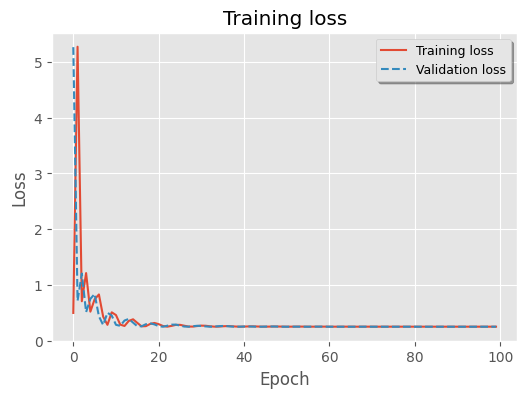

In [30]:
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss", ls="--")
plt.legend(shadow=True, frameon=True, facecolor="inherit", loc="best", fontsize=9)
plt.title("Training loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers


class TransformerAutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, num_heads=4, ff_dim=128, num_layers=2, dropout_rate=0.1):
        super(TransformerAutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Positional Encoding
        self.positional_encoding = PositionalEncoding(input_dim)

        # Transformer-based Encoder
        self.encoder_blocks = [
            TransformerBlock(input_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        self.encoder_dense = layers.Dense(latent_dim, activation='relu')

        # Transformer-based Decoder
        self.decoder_dense = layers.Dense(latent_dim, activation='relu')
        self.decoder_blocks = [
            TransformerBlock(latent_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ]
        self.final_dense = layers.Dense(input_dim)  # Final layer for reconstruction

        # Skip connection
        self.skip_dense = layers.Dense(latent_dim, activation='relu')

    def call(self, X):
        # Add Positional Encoding
        pos_encoded = self.positional_encoding(X)

        # Encoder
        for block in self.encoder_blocks:
            pos_encoded = block(pos_encoded)
        latent = self.encoder_dense(pos_encoded)

        # Pass latent through a skip connection
        skip_connection = self.skip_dense(latent)

        # Decoder
        decoded = skip_connection
        for block in self.decoder_blocks:
            decoded = block(decoded)
        reconstructed = self.final_dense(decoded)

        return reconstructed


class TransformerBlock(layers.Layer):
    def __init__(self, latent_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=latent_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(latent_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        # LayerNorm + Multi-Head Attention
        norm_inputs = self.layernorm1(inputs)
        attn_output = self.attention(norm_inputs, norm_inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output

        # LayerNorm + Feed-Forward Network
        norm_out1 = self.layernorm2(out1)
        ffn_output = self.ffn(norm_out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output


class PositionalEncoding(layers.Layer):
    def __init__(self, input_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._generate_positional_encoding(input_dim, max_len)

    def _generate_positional_encoding(self, input_dim, max_len):
        angle_rads = self._get_angles(
            np.arange(max_len)[:, np.newaxis],
            np.arange(input_dim)[np.newaxis, :],
            input_dim
        )
        # Apply sin to even indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def _get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, X):
        seq_len = tf.shape(X)[1]
        return X + self.positional_encoding[:, :seq_len, :]


# Example Usage
# Assuming X_train has shape (batch_size, sequence_length, features)
X_train = np.random.rand(128, 187, 1).astype(np.float32)  # Example data
input_dim = X_train.shape[-1]
latent_dim = 32

model = TransformerAutoEncoder(input_dim, latent_dim, num_heads=4, ff_dim=128, num_layers=2)
model.build((None, X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mae")
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_auto_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "transformer_auto_encoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ positional_encoding_1                │ ?                           │     0 (unbuilt) │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_6                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_7                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_8                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_9                  │ ?                           │     0 (unbuilt) │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [32]:
epochs = 500
batch_size = 128
early_stopping = EarlyStopping(patience=20, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[])

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 0.2788 - val_loss: 2.2194
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 2.2262 - val_loss: 0.9139
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.9090 - val_loss: 0.7716
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.7828 - val_loss: 0.8728
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.8812 - val_loss: 0.4254
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.4312 - val_loss: 0.3334
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.3354 - val_loss: 0.5508
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.5491 - val_loss: 0.4366
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.4349 - val_loss: 0.2398
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2411 - val_loss: 0.3478
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.3494 - val_loss: 0.4269
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.4282 